# Import

In [1]:
import os, gc, time, json, warnings
from pathlib import Path
from copy import deepcopy
import numpy as np
import pandas as pd
from scipy import io
from scipy.signal import resample_poly
from math import gcd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score,
    roc_curve,
)
try:
    from thop import profile as thop_profile
    HAS_THOP = True
except ImportError:
    HAS_THOP = False

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Configuration

In [2]:
def _find_kaggle_input() -> Path:
    base = Path('/kaggle/input')
    if not base.exists():
        return Path('/kaggle/input/ninapro-db7/Dataset')
    def _has_subjects(p):
        return p.is_dir() and any(
            c.is_dir() and c.name.lower().startswith('subject_')
            for c in p.iterdir()
        )
    def _search(root, depth=0):
        if depth > 5:
            return None
        if _has_subjects(root):
            return root
        try:
            for child in sorted(root.iterdir()):
                if child.is_dir():
                    r = _search(child, depth + 1)
                    if r is not None:
                        return r
        except PermissionError:
            pass
        return None
    r = _search(base)
    return r if r else Path('/kaggle/input/ninapro-db7/Dataset')


class Config:
    # Paths
    KAGGLE_INPUT    = _find_kaggle_input()
    KAGGLE_WORKING  = Path('/kaggle/working')
    CKPT_DIR        = KAGGLE_WORKING / 'ckpts_deepcnn_AB'
    DATA_CACHE_DIR  = KAGGLE_WORKING / 'cache_deepcnn_AB'
    PLOT_DIR        = KAGGLE_WORKING / 'plots_deepcnn_AB'
    RESULTS_DIR     = KAGGLE_WORKING / 'results_deepcnn_AB'

    # Dataset  — identical to TinyMyo notebook
    SUBJECTS        = list(range(1, 23))
    EMG_FS          = 2000
    ACC_FS          = 148
    TARGET_FS       = 2000
    EMG_KEY         = 'emg'
    ACC_KEY         = 'acc'
    LBL_KEY         = 'restimulus'           # fallback: 'stimulus'
    GESTURE_MIN     = 13                     # Exercise B gesture range (inclusive)
    GESTURE_MAX     = 29

    # Windowing  — identical to TinyMyo notebook
    WIN_MS          = 200                    # window length in milliseconds
    STEP_MS         = 100                    # step / hop (50 % overlap)
    WIN_SAMPLES     = int(WIN_MS * TARGET_FS / 1000)   # 400
    STEP_SAMPLES    = int(STEP_MS * TARGET_FS / 1000)  # 200

    # Splits (same two ratios as TinyMyo notebook)
    SPLIT_RATIOS        = [(0.70, 0.30), (0.60, 0.40), (0.50, 0.50)]
    VAL_FRAC_OF_TRAIN   = 0.10              # 10 % of train → validation

    # Training
    MIN_EPOCHS      = 100
    MAX_EPOCHS      = 150
    PATIENCE        = 20
    BATCH_SIZE      = 256
    LR              = 1e-3
    WEIGHT_DECAY    = 1e-4
    NUM_WORKERS     = 2

    # Reproducibility
    SEED            = 42

    # Compute
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


import random
random.seed(Config.SEED)
np.random.seed(Config.SEED)
torch.manual_seed(Config.SEED)
if Config.DEVICE.type == 'cuda':
    torch.cuda.manual_seed_all(Config.SEED)

for d in [Config.CKPT_DIR, Config.DATA_CACHE_DIR,
          Config.PLOT_DIR, Config.RESULTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Device  : {Config.DEVICE}")
print(f"Win     : {Config.WIN_SAMPLES} samples ({Config.WIN_MS} ms)")
print(f"Step    : {Config.STEP_SAMPLES} samples ({Config.STEP_MS} ms)")
print(f"Gestures: {Config.GESTURE_MIN}–{Config.GESTURE_MAX} "
      f"({Config.GESTURE_MAX - Config.GESTURE_MIN + 1} classes)")



Device  : cuda
Win     : 400 samples (200 ms)
Step    : 200 samples (100 ms)
Gestures: 13–29 (17 classes)


# DATA LOADING (EMG + ACC + labels)

In [3]:
class EMGAccPreprocessor:
    """
    Loads EMG, ACC, and labels from a single .mat file.
    ACC is upsampled to EMG rate if its length differs.
    Only rows with gesture labels in [GESTURE_MIN, GESTURE_MAX] are kept.
    Identical to TinyMyo notebook.
    """
    def _find_key(self, data, candidates):
        for c in candidates:
            for k in data:
                if k.lower() == c.lower():
                    return k
        return None

    def apply(self, mat_path: Path):
        data = io.loadmat(str(mat_path))
        emg_key = self._find_key(data, [Config.EMG_KEY])
        acc_key = self._find_key(data, [Config.ACC_KEY, 'glove'])
        lbl_key = self._find_key(
            data, [Config.LBL_KEY, 'stimulus', 'label', 'labels'])

        if emg_key is None:
            raise KeyError(f"No EMG key in {mat_path.name}. "
                           f"Keys: {[k for k in data if not k.startswith('_')]}")
        if lbl_key is None:
            raise KeyError(f"No label key in {mat_path.name}.")

        emg    = data[emg_key].astype(np.float32)
        labels = data[lbl_key].flatten().astype(np.int32)

        # ACC: load if available, else zeros
        if acc_key is not None:
            acc = data[acc_key].astype(np.float32)
            if len(acc) != len(emg):
                factor = len(emg) / len(acc)
                up   = round(factor * Config.ACC_FS)
                down = Config.ACC_FS
                g    = gcd(up, down)
                acc  = resample_poly(acc, up // g, down // g,
                                     axis=0).astype(np.float32)
            if len(acc) > len(emg):
                acc = acc[:len(emg)]
            elif len(acc) < len(emg):
                pad = np.zeros((len(emg) - len(acc), acc.shape[1]),
                               dtype=np.float32)
                acc = np.vstack([acc, pad])
        else:
            acc = np.zeros((len(emg), 0), dtype=np.float32)

        n = min(len(emg), len(labels))
        emg, acc, labels = emg[:n], acc[:n], labels[:n]

        # Keep only Exercise B gestures
        mask   = (labels >= Config.GESTURE_MIN) & (labels <= Config.GESTURE_MAX)
        emg    = emg[mask]
        acc    = acc[mask]
        labels = labels[mask]
        return emg, acc, labels



# Sbject loader

In [4]:
class SubjectLoader:
    """
    Iterates over subjects, loads + checkpoints per-subject data,
    then builds a windowed dataset across all subjects.
    Identical to TinyMyo notebook.
    """
    def __init__(self):
        self.preprocessor = EMGAccPreprocessor()
        self.cache_dir    = Config.DATA_CACHE_DIR

    def _ckpt_path(self, sid: int) -> Path:
        return self.cache_dir / f'subj_{sid:02d}_exB.npz'

    def _find_subject_dir(self, sid: int) -> Path:
        candidates = [
            Config.KAGGLE_INPUT / f'Subject_{sid}',
            Config.KAGGLE_INPUT / f'subject_{sid}',
            Config.KAGGLE_INPUT / f'S{sid}',
            Config.KAGGLE_INPUT / f's{sid}',
        ]
        for p in candidates:
            if p.is_dir():
                return p
        for p in sorted(Config.KAGGLE_INPUT.iterdir()):
            if p.is_dir() and p.name.lower().endswith(str(sid)):
                return p
        raise FileNotFoundError(
            f"Cannot locate folder for subject {sid} under {Config.KAGGLE_INPUT}.")

    def _load_subject(self, sid: int):
        subj_dir  = self._find_subject_dir(sid)
        mat_files = sorted(subj_dir.glob('*.mat'))
        if not mat_files:
            mat_files = sorted(subj_dir.rglob('*.mat'))
        emg_parts, acc_parts, lbl_parts = [], [], []
        for mat_file in mat_files:
            try:
                emg, acc, lbl = self.preprocessor.apply(mat_file)
                if len(emg) > 0:
                    emg_parts.append(emg)
                    acc_parts.append(acc)
                    lbl_parts.append(lbl)
            except Exception as e:
                print(f"  Skip {mat_file.name}: {e}")
        if not emg_parts:
            raise RuntimeError(f"No valid data for subject {sid}")
        emg_all = np.vstack(emg_parts)
        acc_all = np.vstack(acc_parts) if all(
            a.shape[1] > 0 for a in acc_parts) else np.zeros(
            (sum(len(e) for e in emg_parts), 0), dtype=np.float32)
        lbl_all = np.concatenate(lbl_parts)
        return emg_all, acc_all, lbl_all

    def process_all(self, subjects=None):
        subjects  = subjects or Config.SUBJECTS
        available = []
        n_acc_ch  = None
        for sid in tqdm(subjects, desc='Loading subjects'):
            ckpt = self._ckpt_path(sid)
            if ckpt.exists():
                data     = np.load(ckpt, allow_pickle=True)
                n_acc_ch = int(data['n_acc_ch'])
                available.append(sid)
                print(f"  Subject {sid:02d}: checkpoint found "
                      f"({data['n_rows']} rows, {n_acc_ch} ACC ch)")
                continue
            try:
                emg, acc, lbl = self._load_subject(sid)
                n_acc_ch = acc.shape[1]
                np.savez_compressed(
                    ckpt,
                    emg=emg, acc=acc, labels=lbl,
                    n_acc_ch=np.array(n_acc_ch),
                    n_rows=np.array(len(emg)),
                )
                available.append(sid)
                print(f"  Subject {sid:02d}: saved {len(emg):,} rows | "
                      f"EMG {emg.shape[1]} ch | ACC {n_acc_ch} ch")
                del emg, acc, lbl
                gc.collect()
            except Exception as exc:
                print(f"  Subject {sid:02d}: FAILED — {exc}")
        return available, (n_acc_ch or 0)

    def build_windows(self, subjects, n_acc_ch):
        """
        Slide windows over each subject's signal and return
        (X, y) arrays ready for model input.
        X shape: (N, n_channels, WIN_SAMPLES)
        y shape: (N,) — zero-indexed class labels
        """
        W      = Config.WIN_SAMPLES
        S      = Config.STEP_SAMPLES
        X_list, y_list = [], []
        for sid in tqdm(subjects, desc='Windowing'):
            ckpt = self._ckpt_path(sid)
            if not ckpt.exists():
                continue
            d      = np.load(ckpt)
            emg    = d['emg'].astype(np.float32)
            acc    = d['acc'].astype(np.float32)
            labels = d['labels'].astype(np.int32)
            sig    = np.concatenate([emg, acc], axis=1) if acc.shape[1] > 0 else emg
            n_ch   = sig.shape[1]
            T      = len(sig)
            for start in range(0, T - W + 1, S):
                end  = start + W
                seg  = sig[start:end]
                lbls = labels[start:end]
                lbl  = int(np.bincount(
                    lbls - Config.GESTURE_MIN,
                    minlength=Config.GESTURE_MAX - Config.GESTURE_MIN + 1
                ).argmax())
                X_list.append(seg.T)
                y_list.append(lbl)
            del emg, acc, labels, sig, d
            gc.collect()
        X = np.stack(X_list, axis=0).astype(np.float32)
        y = np.array(y_list, dtype=np.int64)
        print(f"\nWindowed dataset: X={X.shape} y={y.shape} "
              f"classes={np.unique(y).tolist()}")
        return X, y, n_ch


# Normalization

In [5]:
class ChannelNormalizer:
    """Per-channel z-score normalization fit on training data."""
    def __init__(self):
        self.mean = None   # (1, C, 1)
        self.std  = None

    def fit(self, X: np.ndarray):
        self.mean = X.mean(axis=(0, 2), keepdims=True)
        self.std  = X.std(axis=(0, 2),  keepdims=True) + 1e-8
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        return (X - self.mean) / self.std

    def fit_transform(self, X: np.ndarray) -> np.ndarray:
        return self.fit(X).transform(X)


# Torch Dataset

In [6]:
class EMGWindowDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DeepCNN Model

In [7]:
class _ResBlock(nn.Module):
    """
    Residual block: two Conv1d layers with BN + ReLU, plus a skip connection.
    If in_ch != out_ch, the skip uses a 1×1 conv.
    """
    def __init__(self, in_ch: int, out_ch: int, kernel: int = 3,
                 stride: int = 1, dropout: float = 0.2):
        super().__init__()
        pad = kernel // 2
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel, stride=stride, padding=pad, bias=False),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(out_ch, out_ch, kernel, padding=pad, bias=False),
            nn.BatchNorm1d(out_ch),
        )
        self.drop  = nn.Dropout(dropout)
        self.skip  = (
            nn.Sequential(
                nn.Conv1d(in_ch, out_ch, 1, stride=stride, bias=False),
                nn.BatchNorm1d(out_ch),
            )
            if (in_ch != out_ch or stride != 1) else nn.Identity()
        )
        self.relu  = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.drop(out)
        return self.relu(out + self.skip(x))


class DeepCNN(nn.Module):
    """
    Deep residual CNN for sEMG gesture classification.

    Architecture:
      Stem          : Conv1d(C, 64, k=7) → BN → ReLU → MaxPool(2)
      Stage 1       : 2 × ResBlock(64, 64)
      Downsample    : ResBlock(64, 128, stride=2)
      Stage 2       : 2 × ResBlock(128, 128)
      Downsample    : ResBlock(128, 256, stride=2)
      Stage 3       : 2 × ResBlock(256, 256)
      Downsample    : ResBlock(256, 512, stride=2)
      Stage 4       : 2 × ResBlock(512, 512)
      Global AdaptiveAvgPool → Dropout → Linear(512, n_classes)

    Input : (B, n_channels, WIN_SAMPLES)   ← fixed at (1, C, 400) for GFLOPs
    Output: (B, n_classes)
    """
    def __init__(self, n_channels: int, n_classes: int,
                 dropout: float = 0.4):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes

        # Stem
        self.stem = nn.Sequential(
            nn.Conv1d(n_channels, 64, kernel_size=7, padding=3, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),          # T/2
        )

        # Residual stages
        self.stage1 = nn.Sequential(
            _ResBlock(64,  64,  dropout=dropout),
            _ResBlock(64,  64,  dropout=dropout),
        )
        self.down1 = _ResBlock(64,  128, stride=2, dropout=dropout)   # T/4

        self.stage2 = nn.Sequential(
            _ResBlock(128, 128, dropout=dropout),
            _ResBlock(128, 128, dropout=dropout),
        )
        self.down2 = _ResBlock(128, 256, stride=2, dropout=dropout)   # T/8

        self.stage3 = nn.Sequential(
            _ResBlock(256, 256, dropout=dropout),
            _ResBlock(256, 256, dropout=dropout),
        )
        self.down3 = _ResBlock(256, 512, stride=2, dropout=dropout)   # T/16

        self.stage4 = nn.Sequential(
            _ResBlock(512, 512, dropout=dropout),
            _ResBlock(512, 512, dropout=dropout),
        )

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(512, n_classes),
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.down1(x)
        x = self.stage2(x)
        x = self.down2(x)
        x = self.stage3(x)
        x = self.down3(x)
        x = self.stage4(x)
        x = self.pool(x).squeeze(-1)   # (B, 512)
        return self.head(x)             # (B, n_classes)

    def count_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# GFLOPs

In [8]:
def compute_gflops(model, n_channels, win_samples=Config.WIN_SAMPLES):
    """GFLOPs for a single forward pass at fixed input (1, C, WIN_SAMPLES)."""
    if HAS_THOP:
        dummy       = torch.zeros(1, n_channels, win_samples)
        macs, _     = thop_profile(deepcopy(model).cpu(), inputs=(dummy,), verbose=False)
        return macs * 2 / 1e9
    else:
        return -1.0

# Trainer

In [9]:
class Trainer:
    """
    Trains DeepCNN until plateau or MAX_EPOCHS (at least MIN_EPOCHS).
    Saves best checkpoint by validation loss.
    Returns training history.
    """
    def __init__(self, model, save_path: Path, n_classes: int):
        self.model     = model.to(Config.DEVICE)
        self.save_path = save_path
        self.n_classes = n_classes
        self.history   = {'train_loss': [], 'val_loss': [],
                          'train_acc':  [], 'val_acc': []}

    def _run_epoch(self, loader, optimizer=None, criterion=None):
        training = optimizer is not None
        self.model.train(training)
        total_loss, correct, total = 0.0, 0, 0
        ctx = torch.enable_grad() if training else torch.no_grad()
        with ctx:
            for X, y in loader:
                X, y  = X.to(Config.DEVICE), y.to(Config.DEVICE)
                logits = self.model(X)
                loss   = criterion(logits, y)
                if training:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                total_loss += loss.item() * len(y)
                correct    += (logits.argmax(1) == y).sum().item()
                total      += len(y)
        return total_loss / total, correct / total

    def fit(self, train_loader, val_loader):
        optimizer  = Adam(self.model.parameters(),
                          lr=Config.LR, weight_decay=Config.WEIGHT_DECAY)
        criterion  = nn.CrossEntropyLoss()
        scheduler  = CosineAnnealingLR(optimizer, T_max=Config.MAX_EPOCHS)
        best_val_loss = float('inf')
        patience_cnt  = 0
        start_wall    = time.perf_counter()

        for epoch in range(1, Config.MAX_EPOCHS + 1):
            tr_loss, tr_acc = self._run_epoch(train_loader, optimizer, criterion)
            vl_loss, vl_acc = self._run_epoch(val_loader, criterion=criterion)
            scheduler.step()
            self.history['train_loss'].append(tr_loss)
            self.history['val_loss'].append(vl_loss)
            self.history['train_acc'].append(tr_acc)
            self.history['val_acc'].append(vl_acc)

            if vl_loss < best_val_loss:
                best_val_loss = vl_loss
                patience_cnt  = 0
                torch.save(self.model.state_dict(), self.save_path)
            else:
                patience_cnt += 1

            if epoch % 10 == 0:
                print(f"  Epoch {epoch:3d} "
                      f"train_loss={tr_loss:.4f} train_acc={tr_acc:.4f} "
                      f"val_loss={vl_loss:.4f} val_acc={vl_acc:.4f}")

            # Early stopping: only after MIN_EPOCHS
            if epoch >= Config.MIN_EPOCHS and patience_cnt >= Config.PATIENCE:
                print(f"  Early stop at epoch {epoch} (patience={Config.PATIENCE})")
                break

        self.train_wall = time.perf_counter() - start_wall
        print(f"  Training wall-clock: {self.train_wall:.1f} s "
              f"| Best val_loss: {best_val_loss:.4f}")
        return self


#  Evaluator

In [10]:
class Evaluator:
    """
    Loads the best saved model and computes the full metric suite
    on the test set.
    """
    def __init__(self, model_cls, model_kwargs, save_path: Path,
                 n_classes: int, class_names: list):
        self.model_cls   = model_cls
        self.model_kwargs = model_kwargs
        self.save_path   = save_path
        self.n_classes   = n_classes
        self.class_names = class_names

    def _load_model(self):
        model = self.model_cls(**self.model_kwargs)
        model.load_state_dict(torch.load(self.save_path,
                                         map_location=Config.DEVICE))
        model.to(Config.DEVICE).eval()
        return model

    def evaluate(self, test_loader, split_tag: str) -> dict:
        model = self._load_model()
        all_preds, all_proba, all_true = [], [], []
        start_wall = time.perf_counter()
        with torch.no_grad():
            for X, y in test_loader:
                X      = X.to(Config.DEVICE)
                logits = model(X)
                proba  = torch.softmax(logits, dim=1).cpu().numpy()
                preds  = logits.argmax(1).cpu().numpy()
                all_proba.append(proba)
                all_preds.append(preds)
                all_true.append(y.numpy())
        test_wall = time.perf_counter() - start_wall

        all_proba = np.vstack(all_proba)
        all_preds = np.concatenate(all_preds)
        all_true  = np.concatenate(all_true)
        n_test    = len(all_true)

        acc_overall   = accuracy_score(all_true, all_preds)
        per_class_acc = {}
        for c in range(self.n_classes):
            mask = all_true == c
            if mask.sum() > 0:
                per_class_acc[self.class_names[c]] = float(
                    accuracy_score(all_true[mask], all_preds[mask]))

        precision = precision_score(all_true, all_preds,
                                    average='weighted', zero_division=0)
        recall    = recall_score(all_true, all_preds,
                                 average='weighted', zero_division=0)
        f1        = f1_score(all_true, all_preds,
                             average='weighted', zero_division=0)
        try:
            roc_auc = roc_auc_score(all_true, all_proba,
                                    multi_class='ovr', average='weighted',
                                    labels=list(range(self.n_classes)))
        except Exception:
            roc_auc = float('nan')

        gflops = compute_gflops(model, model.n_channels)

        metrics = {
            'split':             split_tag,
            'accuracy':          acc_overall,
            'precision_w':       precision,
            'recall_w':          recall,
            'f1_w':              f1,
            'roc_auc_w':         roc_auc,
            'per_class_acc':     per_class_acc,
            'test_wall_s':       test_wall,
            'test_samples':      n_test,
            'gflops_per_window': gflops,
            'input_size':        f"(1, {model.n_channels}, {Config.WIN_SAMPLES})",
        }

        tag = split_tag.replace(':', '_')
        self._plot_confusion(all_true, all_preds, split_tag, tag)
        self._plot_roc(all_true, all_proba, split_tag, tag)
        return metrics, all_true, all_proba

    def _plot_confusion(self, y_true, y_pred, title, tag):
        cm  = confusion_matrix(y_true, y_pred, labels=list(range(self.n_classes)))
        cmn = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-8)
        fig, axes = plt.subplots(1, 2, figsize=(18, 7))
        for ax, mat, label in zip(axes,
                                   [cm, cmn],
                                   ['Count', 'Normalised']):
            sns.heatmap(mat, ax=ax, cmap='Blues',
                        xticklabels=self.class_names,
                        yticklabels=self.class_names,
                        annot=(self.n_classes <= 17),
                        fmt='.2f' if label == 'Normalised' else 'd',
                        linewidths=0.3)
            ax.set_title(f"Confusion Matrix ({label}) — DeepCNN {title}", fontsize=11)
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.tick_params(axis='x', rotation=45, labelsize=8)
            ax.tick_params(axis='y', rotation=0,  labelsize=8)
        plt.tight_layout()
        path = Config.PLOT_DIR / f'cm_{tag}.png'
        plt.savefig(path, dpi=120, bbox_inches='tight')
        plt.show()
        plt.close('all')
        print(f"  CM saved → {path.name}")

    def _plot_roc(self, y_true, y_proba, title, tag):
        fig, ax = plt.subplots(figsize=(10, 7))
        colors  = plt.cm.tab20(np.linspace(0, 1, self.n_classes))
        for c in range(self.n_classes):
            if (y_true == c).sum() == 0:
                continue
            fpr, tpr, _ = roc_curve((y_true == c).astype(int), y_proba[:, c])
            try:
                auc_c = roc_auc_score((y_true == c).astype(int), y_proba[:, c])
            except Exception:
                auc_c = float('nan')
            ax.plot(fpr, tpr, color=colors[c], lw=1.2,
                    label=f"{self.class_names[c]} (AUC={auc_c:.2f})")
        ax.plot([0, 1], [0, 1], 'k--', lw=0.8)
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title(f"ROC Curves (OvR) — DeepCNN {title}", fontsize=11)
        ax.legend(fontsize=7, ncol=2, loc='lower right')
        plt.tight_layout()
        path = Config.PLOT_DIR / f'roc_{tag}.png'
        plt.savefig(path, dpi=120, bbox_inches='tight')
        plt.show()
        plt.close('all')
        print(f"  ROC saved → {path.name}")


# Learning-Curve Plotter

In [11]:
def plot_learning_curves(history: dict, split_tag: str):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    epochs = range(1, len(history['train_loss']) + 1)
    axes[0].plot(epochs, history['train_loss'], label='Train loss')
    axes[0].plot(epochs, history['val_loss'],   label='Val loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Cross-entropy loss')
    axes[0].set_title(f'DeepCNN Learning Curve (Loss) — {split_tag}')
    axes[0].legend()
    axes[1].plot(epochs, history['train_acc'], label='Train acc')
    axes[1].plot(epochs, history['val_acc'],   label='Val acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title(f'DeepCNN Learning Curve (Accuracy) — {split_tag}')
    axes[1].legend()
    plt.tight_layout()
    tag  = split_tag.replace(':', '_')
    path = Config.PLOT_DIR / f'curves_{tag}.png'
    plt.savefig(path, dpi=120, bbox_inches='tight')
    plt.show()
    plt.close('all')
    print(f"  Curves saved → {path.name}")


# Experiment Runner (one split ratio)

In [12]:
class SplitExperiment:
    def __init__(self, X: np.ndarray, y: np.ndarray,
                 n_channels: int, n_classes: int, class_names: list):
        self.X           = X
        self.y           = y
        self.n_channels  = n_channels
        self.n_classes   = n_classes
        self.class_names = class_names

    def run(self, train_frac: float, test_frac: float) -> dict:
        tag = f"{int(train_frac*100)}:{int(test_frac*100)}"
        print(f"\n{'='*70}")
        print(f"  Split {tag} | train={train_frac:.0%} test={test_frac:.0%}")
        print(f"{'='*70}")

        # Train / test split
        X_trainval, X_test, y_trainval, y_test = train_test_split(
            self.X, self.y,
            test_size=test_frac,
            random_state=Config.SEED,
            stratify=self.y,
        )

        # Train / val split (10 % of train portion)
        stratify_tv = (y_trainval
                       if len(np.unique(y_trainval)) == self.n_classes
                       else None)
        X_train, X_val, y_train, y_val = train_test_split(
            X_trainval, y_trainval,
            test_size=Config.VAL_FRAC_OF_TRAIN,
            random_state=Config.SEED,
            stratify=stratify_tv,
        )

        print(f"  Sizes  train={len(y_train):,} val={len(y_val):,} test={len(y_test):,}")

        # Normalize
        normalizer = ChannelNormalizer()
        X_train    = normalizer.fit_transform(X_train)
        X_val      = normalizer.transform(X_val)
        X_test     = normalizer.transform(X_test)

        # Data loaders
        tr_loader  = DataLoader(EMGWindowDataset(X_train, y_train),
                                batch_size=Config.BATCH_SIZE, shuffle=True,
                                num_workers=Config.NUM_WORKERS, pin_memory=True)
        val_loader = DataLoader(EMGWindowDataset(X_val, y_val),
                                batch_size=Config.BATCH_SIZE, shuffle=False,
                                num_workers=Config.NUM_WORKERS, pin_memory=True)
        tst_loader = DataLoader(EMGWindowDataset(X_test, y_test),
                                batch_size=Config.BATCH_SIZE, shuffle=False,
                                num_workers=Config.NUM_WORKERS, pin_memory=True)

        # Build model
        model_kwargs = dict(n_channels=self.n_channels, n_classes=self.n_classes)
        model        = DeepCNN(**model_kwargs)
        save_path    = Config.CKPT_DIR / f'deepcnn_{tag.replace(":", "_")}.pt'
        gflops       = compute_gflops(model, self.n_channels)
        print(f"  DeepCNN params   : {model.count_params():,}")
        print(f"  GFLOPs/window    : {gflops:.4f} "
              f"(input {self.n_channels}×{Config.WIN_SAMPLES})")

        # Train
        trainer = Trainer(model, save_path, self.n_classes)
        trainer.fit(tr_loader, val_loader)
        plot_learning_curves(trainer.history, tag)

        # Evaluate (load best checkpoint)
        evaluator = Evaluator(DeepCNN, model_kwargs, save_path,
                              self.n_classes, self.class_names)
        metrics, y_true, y_proba = evaluator.evaluate(tst_loader, tag)

        # Attach training info
        metrics['train_wall_s']    = trainer.train_wall
        metrics['gflops_per_window'] = gflops
        metrics['n_params']        = model.count_params()
        metrics['epochs_trained']  = len(trainer.history['train_loss'])
        metrics['train_size']      = int(len(y_train))
        metrics['val_size']        = int(len(y_val))
        metrics['test_size']       = int(len(y_test))

        # Pretty print
        print(f"\n  Results {tag}")
        print(f"  Accuracy      : {metrics['accuracy']:.4f}")
        print(f"  Precision (W) : {metrics['precision_w']:.4f}")
        print(f"  Recall (W)    : {metrics['recall_w']:.4f}")
        print(f"  F1 (W)        : {metrics['f1_w']:.4f}")
        print(f"  ROC-AUC (W)   : {metrics['roc_auc_w']:.4f}")
        print(f"  Train wall    : {metrics['train_wall_s']:.1f} s")
        print(f"  Test wall     : {metrics['test_wall_s']:.2f} s")
        print(f"  GFLOPs/win    : {gflops:.4f}")
        print(f"  Model saved  → {save_path.name}")
        return metrics, y_true, y_proba

# Failure Mode Analysis 

In [13]:
def analyse_failure_modes(all_metrics: list, class_names: list):
    """
    Aggregates per-class accuracy across all splits and identifies the
    most confused gesture pairs.
    """
    print(f"\n{'='*70}")
    print("  FAILURE MODE ANALYSIS — DeepCNN")
    print(f"{'='*70}")

    class_accs = {c: [] for c in class_names}
    for m in all_metrics:
        for c, acc in m.get('per_class_acc', {}).items():
            if c in class_accs:
                class_accs[c].append(acc)

    mean_class_acc = {c: np.mean(v) for c, v in class_accs.items() if v}
    sorted_acc     = sorted(mean_class_acc.items(), key=lambda x: x[1])

    print("\n  Per-class mean accuracy (worst → best):")
    for name, acc in sorted_acc:
        bar = '█' * int(acc * 30)
        print(f"    {name:>12s}  {acc:.3f}  {bar}")

    best_idx = int(np.argmax([m['f1_w'] for m in all_metrics]))
    best     = all_metrics[best_idx]
    print(f"\n  BEST split (by weighted F1): {best['split']}")
    print(f"  Accuracy : {best['accuracy']:.4f}")
    print(f"  F1 (W)   : {best['f1_w']:.4f}")
    print(f"  ROC-AUC  : {best['roc_auc_w']:.4f}")
    print(f"  → Use split {best['split']} as the reference baseline for SSL.\n")

    splits = [m['split'] for m in all_metrics]
    accs   = [m['accuracy'] for m in all_metrics]
    f1s    = [m['f1_w'] for m in all_metrics]

    fig, ax = plt.subplots(figsize=(10, 5))
    x  = np.arange(len(splits))
    w  = 0.35
    ax.bar(x - w/2, accs, w, label='Accuracy', color='steelblue')
    ax.bar(x + w/2, f1s,  w, label='F1 (weighted)', color='coral')
    ax.set_xticks(x)
    ax.set_xticklabels(splits, rotation=30)
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1.05)
    ax.set_title('DeepCNN — Accuracy & Weighted F1 across Splits')
    ax.legend()
    ax.axhline(max(f1s), color='red', linestyle='--', lw=0.8,
               label=f'Best F1={max(f1s):.3f}')
    plt.tight_layout()
    path = Config.PLOT_DIR / 'summary_all_splits.png'
    plt.savefig(path, dpi=120, bbox_inches='tight')
    plt.show()
    plt.close('all')
    print(f"  Summary chart saved → {path.name}")
    return best


# Main 🤲🏻


  STEP 1 — Loading NinaPro DB7 (Exercise B gestures 13-29)


Loading subjects:   0%|          | 0/22 [00:00<?, ?it/s]

  Subject 01: saved 836,278 rows | EMG 12 ch | ACC 36 ch
  Subject 02: saved 981,857 rows | EMG 12 ch | ACC 36 ch
  Subject 03: saved 793,505 rows | EMG 12 ch | ACC 36 ch
  Subject 04: saved 1,030,056 rows | EMG 12 ch | ACC 36 ch
  Subject 05: saved 727,456 rows | EMG 12 ch | ACC 36 ch
  Subject 06: saved 791,365 rows | EMG 12 ch | ACC 36 ch
  Subject 07: saved 633,593 rows | EMG 12 ch | ACC 36 ch
  Subject 08: saved 740,815 rows | EMG 12 ch | ACC 36 ch
  Subject 09: saved 802,119 rows | EMG 12 ch | ACC 36 ch
  Subject 10: saved 723,376 rows | EMG 12 ch | ACC 36 ch
  Subject 11: saved 1,043,164 rows | EMG 12 ch | ACC 36 ch
  Subject 12: saved 750,726 rows | EMG 12 ch | ACC 36 ch
  Subject 13: saved 830,746 rows | EMG 12 ch | ACC 36 ch
  Subject 14: saved 803,185 rows | EMG 12 ch | ACC 36 ch
  Subject 15: saved 818,191 rows | EMG 12 ch | ACC 36 ch
  Subject 16: saved 801,268 rows | EMG 12 ch | ACC 36 ch
  Subject 17: saved 734,520 rows | EMG 12 ch | ACC 36 ch
  Subject 18: saved 792,861

Windowing:   0%|          | 0/22 [00:00<?, ?it/s]


Windowed dataset: X=(87614, 48, 400) y=(87614,) classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

  Total windows  : 87,614
  Input channels : 48 (EMG=12, ACC=36)
  Window size    : 400 samples (200 ms @ 2000 Hz)
  Classes        : 17 → ['G13', 'G14', 'G15', 'G16', 'G17', 'G18', 'G19', 'G20', 'G21', 'G22', 'G23', 'G24', 'G25', 'G26', 'G27', 'G28', 'G29']
       G13:   4,701 windows (5.4%)
       G14:   4,298 windows (4.9%)
       G15:   4,150 windows (4.7%)
       G16:   5,088 windows (5.8%)
       G17:   4,374 windows (5.0%)
       G18:   4,898 windows (5.6%)
       G19:   5,070 windows (5.8%)
       G20:   4,873 windows (5.6%)
       G21:   5,090 windows (5.8%)
       G22:   5,348 windows (6.1%)
       G23:   5,248 windows (6.0%)
       G24:   6,457 windows (7.4%)
       G25:   5,463 windows (6.2%)
       G26:   6,465 windows (7.4%)
       G27:   5,225 windows (6.0%)
       G28:   5,399 windows (6.2%)
       G29:   5,467 windows (6.2%)

  STEP 3 — Training & Evalua

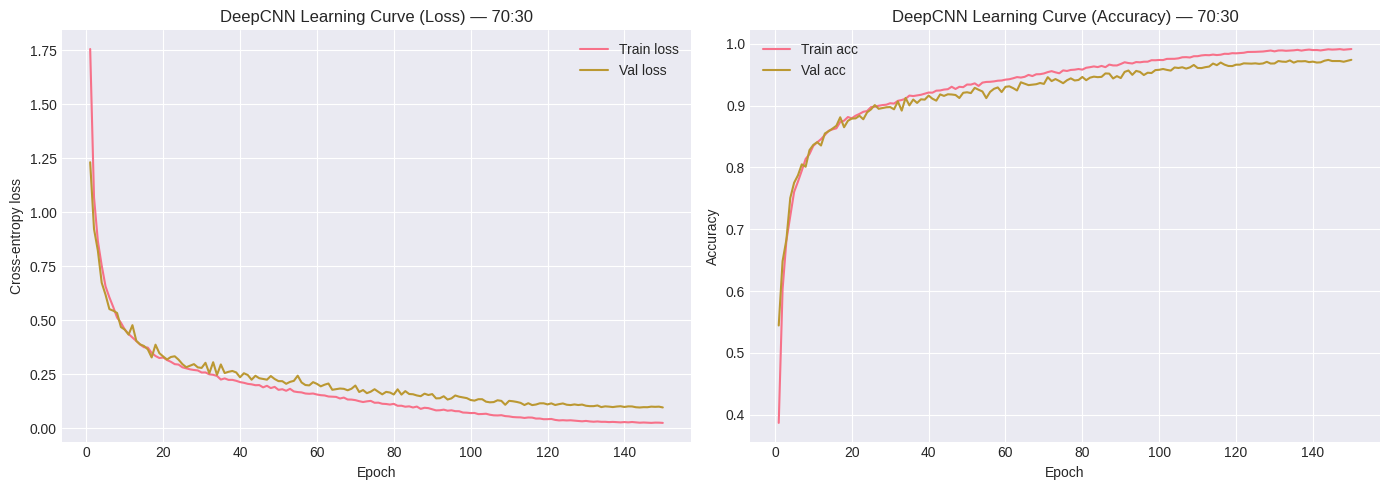

  Curves saved → curves_70_30.png


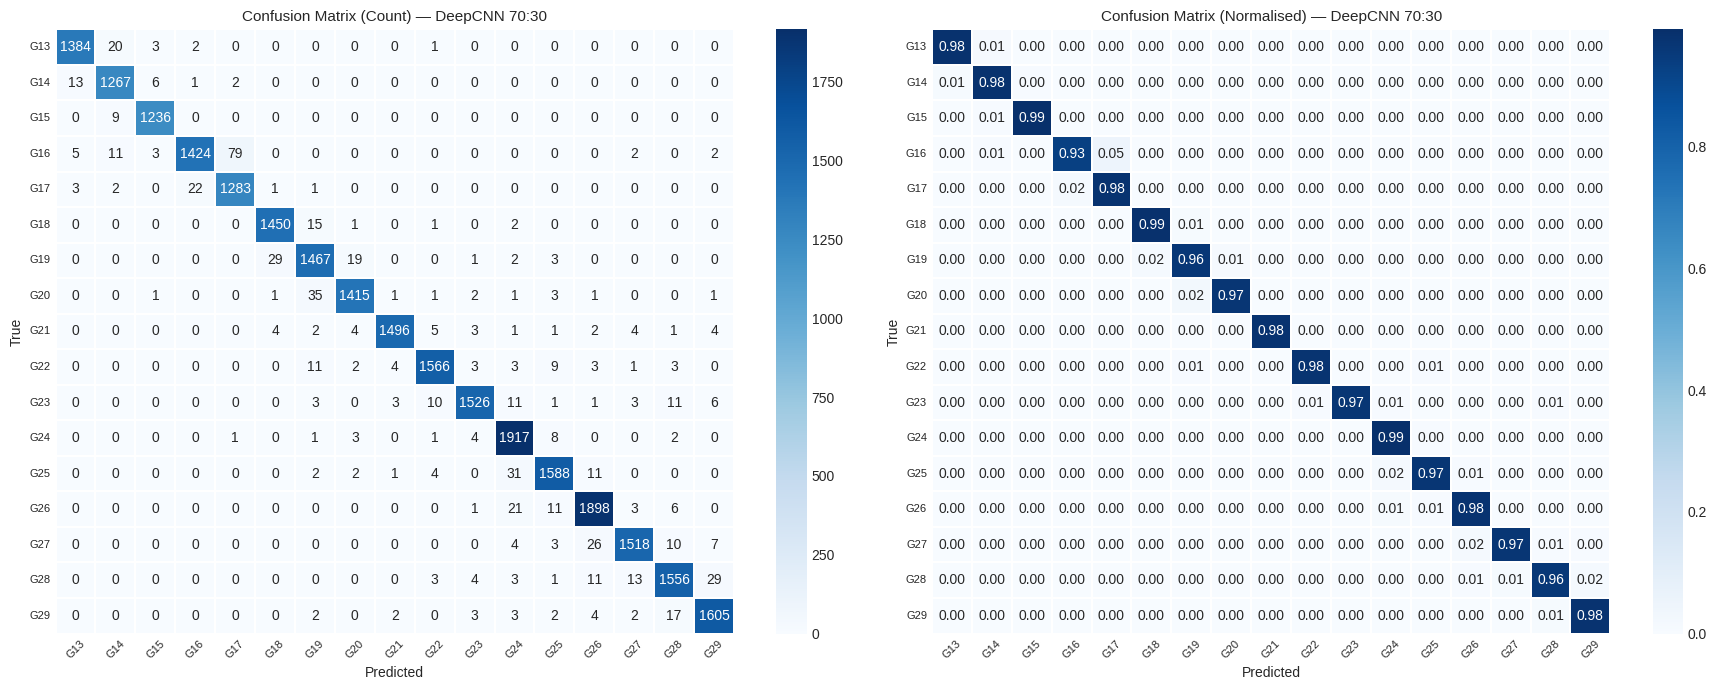

  CM saved → cm_70_30.png


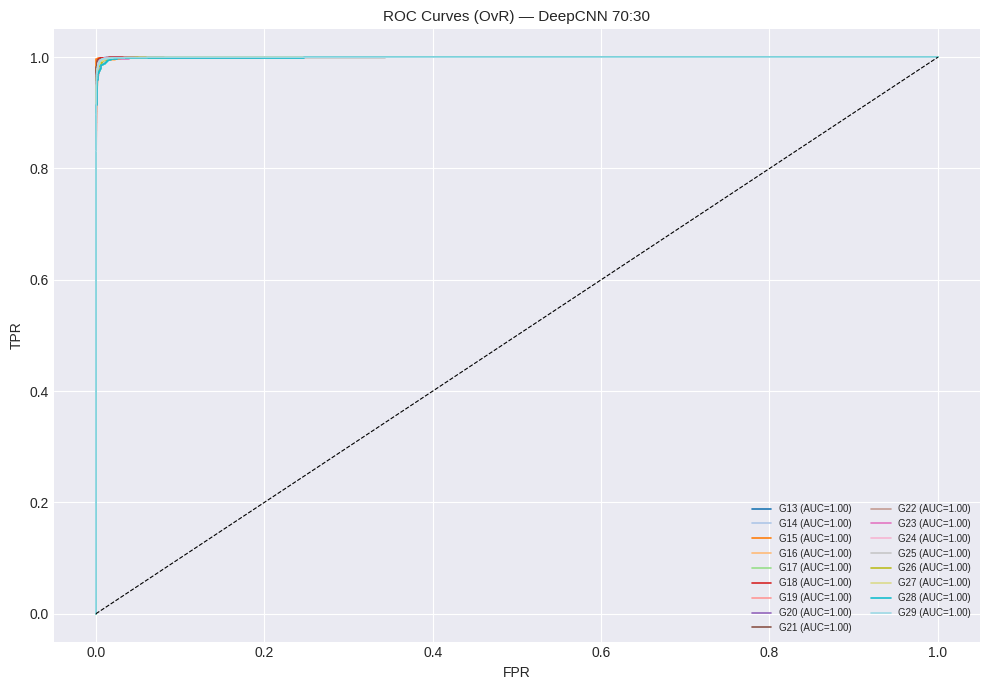

  ROC saved → roc_70_30.png

  Results 70:30
  Accuracy      : 0.9738
  Precision (W) : 0.9740
  Recall (W)    : 0.9738
  F1 (W)        : 0.9738
  ROC-AUC (W)   : 0.9997
  Train wall    : 4866.2 s
  Test wall     : 4.28 s
  GFLOPs/win    : -1.0000
  Model saved  → deepcnn_70_30.pt

  Split 60:40 | train=60% test=40%
  Sizes  train=47,311 val=5,257 test=35,046
  DeepCNN params   : 5,941,649
  GFLOPs/window    : -1.0000 (input 48×400)
  Epoch  10 train_loss=0.5215 train_acc=0.8097 val_loss=0.4672 val_acc=0.8303
  Epoch  20 train_loss=0.3473 train_acc=0.8739 val_loss=0.3515 val_acc=0.8754
  Epoch  30 train_loss=0.2846 train_acc=0.8948 val_loss=0.3240 val_acc=0.8819
  Epoch  40 train_loss=0.2368 train_acc=0.9125 val_loss=0.2594 val_acc=0.9056
  Epoch  50 train_loss=0.1991 train_acc=0.9269 val_loss=0.2380 val_acc=0.9173
  Epoch  60 train_loss=0.1715 train_acc=0.9365 val_loss=0.2156 val_acc=0.9270
  Epoch  70 train_loss=0.1419 train_acc=0.9480 val_loss=0.2114 val_acc=0.9308
  Epoch  80 train

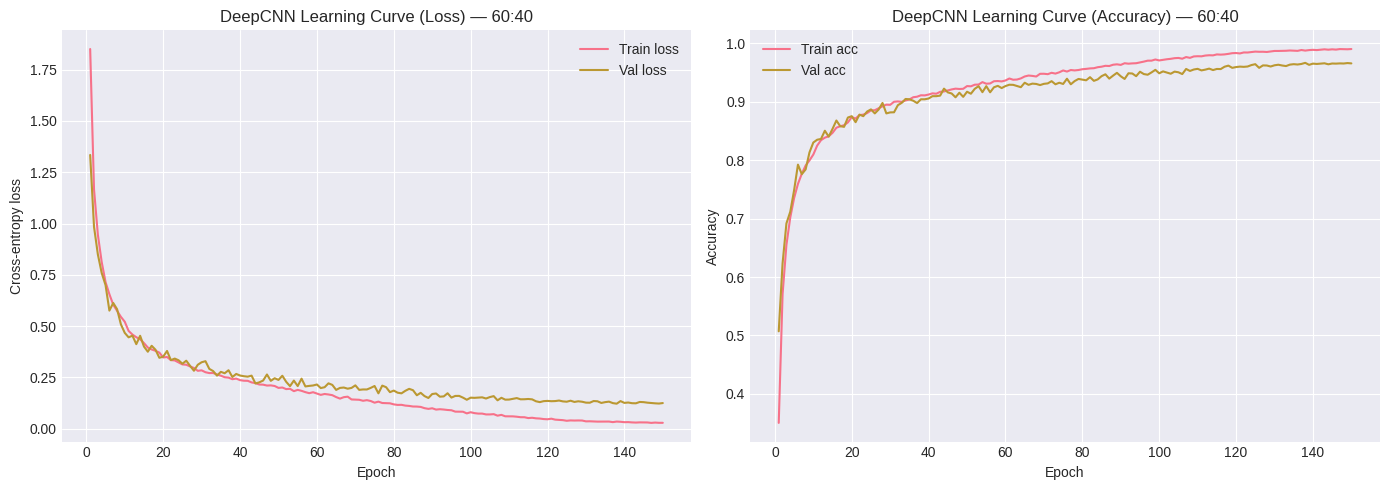

  Curves saved → curves_60_40.png


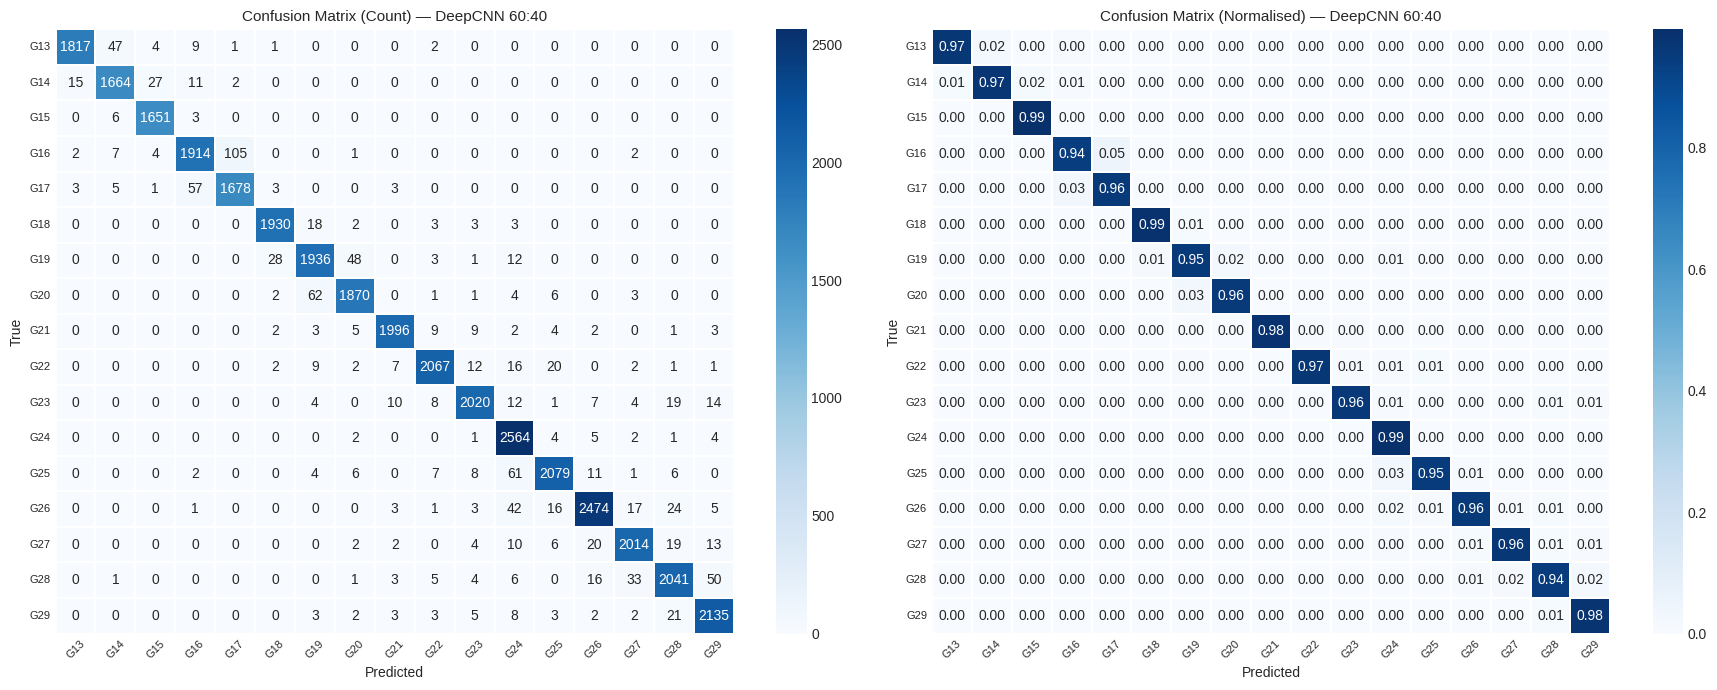

  CM saved → cm_60_40.png


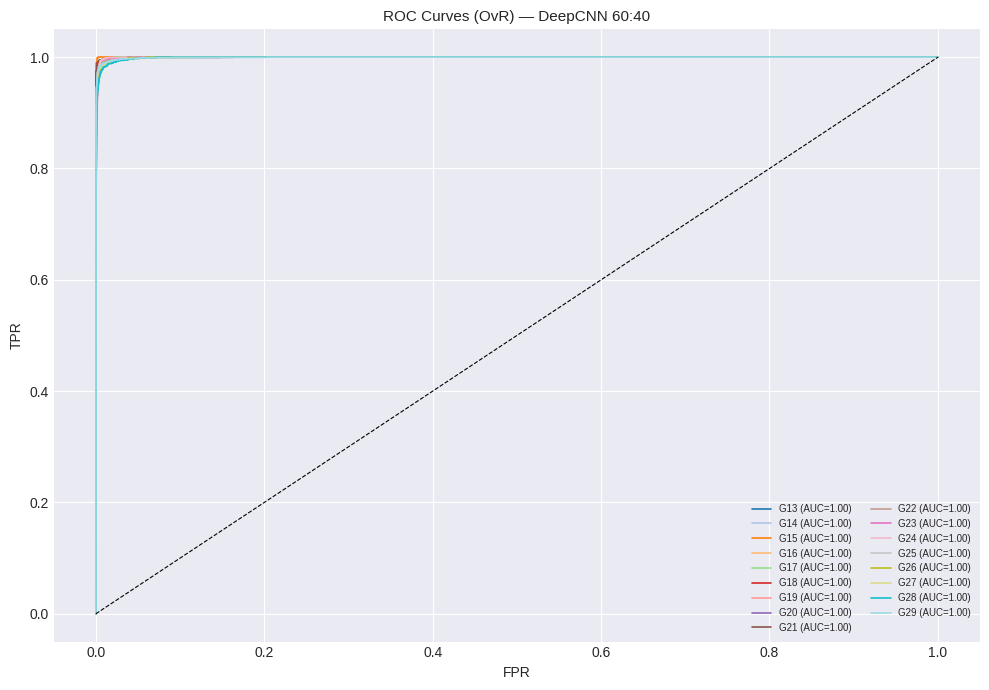

  ROC saved → roc_60_40.png

  Results 60:40
  Accuracy      : 0.9659
  Precision (W) : 0.9661
  Recall (W)    : 0.9659
  F1 (W)        : 0.9659
  ROC-AUC (W)   : 0.9995
  Train wall    : 4162.4 s
  Test wall     : 5.46 s
  GFLOPs/win    : -1.0000
  Model saved  → deepcnn_60_40.pt

  Split 50:50 | train=50% test=50%
  Sizes  train=39,426 val=4,381 test=43,807
  DeepCNN params   : 5,941,649
  GFLOPs/window    : -1.0000 (input 48×400)
  Epoch  10 train_loss=0.7162 train_acc=0.7378 val_loss=0.7969 val_acc=0.7176
  Epoch  20 train_loss=0.5652 train_acc=0.7959 val_loss=0.5999 val_acc=0.7866
  Epoch  30 train_loss=0.4593 train_acc=0.8306 val_loss=0.6097 val_acc=0.7950
  Epoch  40 train_loss=0.3538 train_acc=0.8708 val_loss=0.4298 val_acc=0.8484
  Epoch  50 train_loss=0.3362 train_acc=0.8791 val_loss=0.3529 val_acc=0.8735
  Epoch  60 train_loss=0.3352 train_acc=0.8801 val_loss=0.4098 val_acc=0.8605
  Epoch  70 train_loss=0.2416 train_acc=0.9116 val_loss=0.2793 val_acc=0.9060
  Epoch  80 train

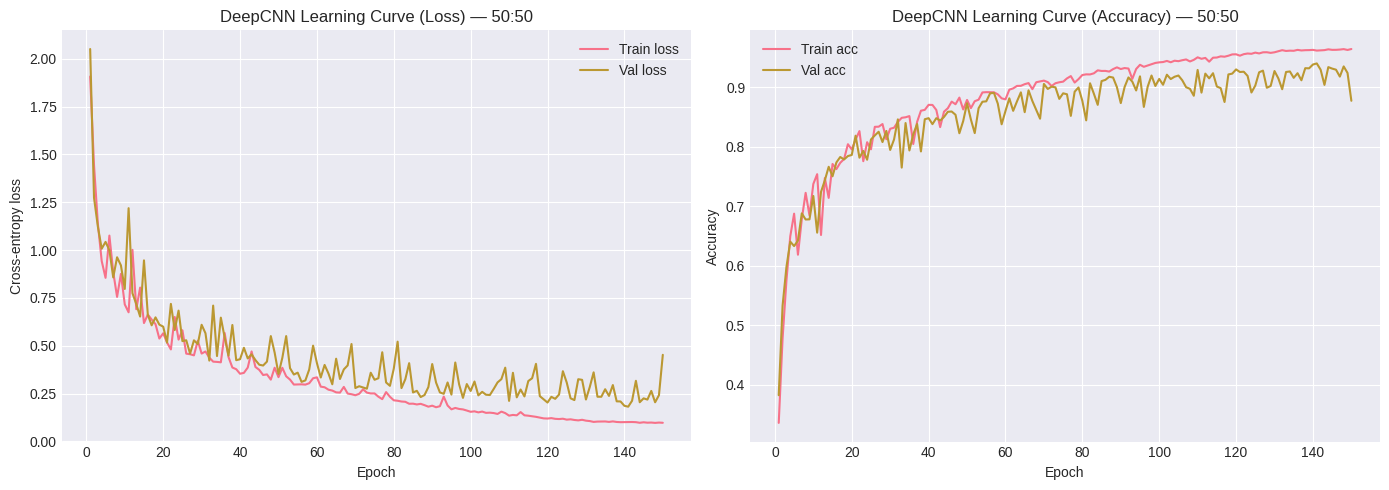

  Curves saved → curves_50_50.png


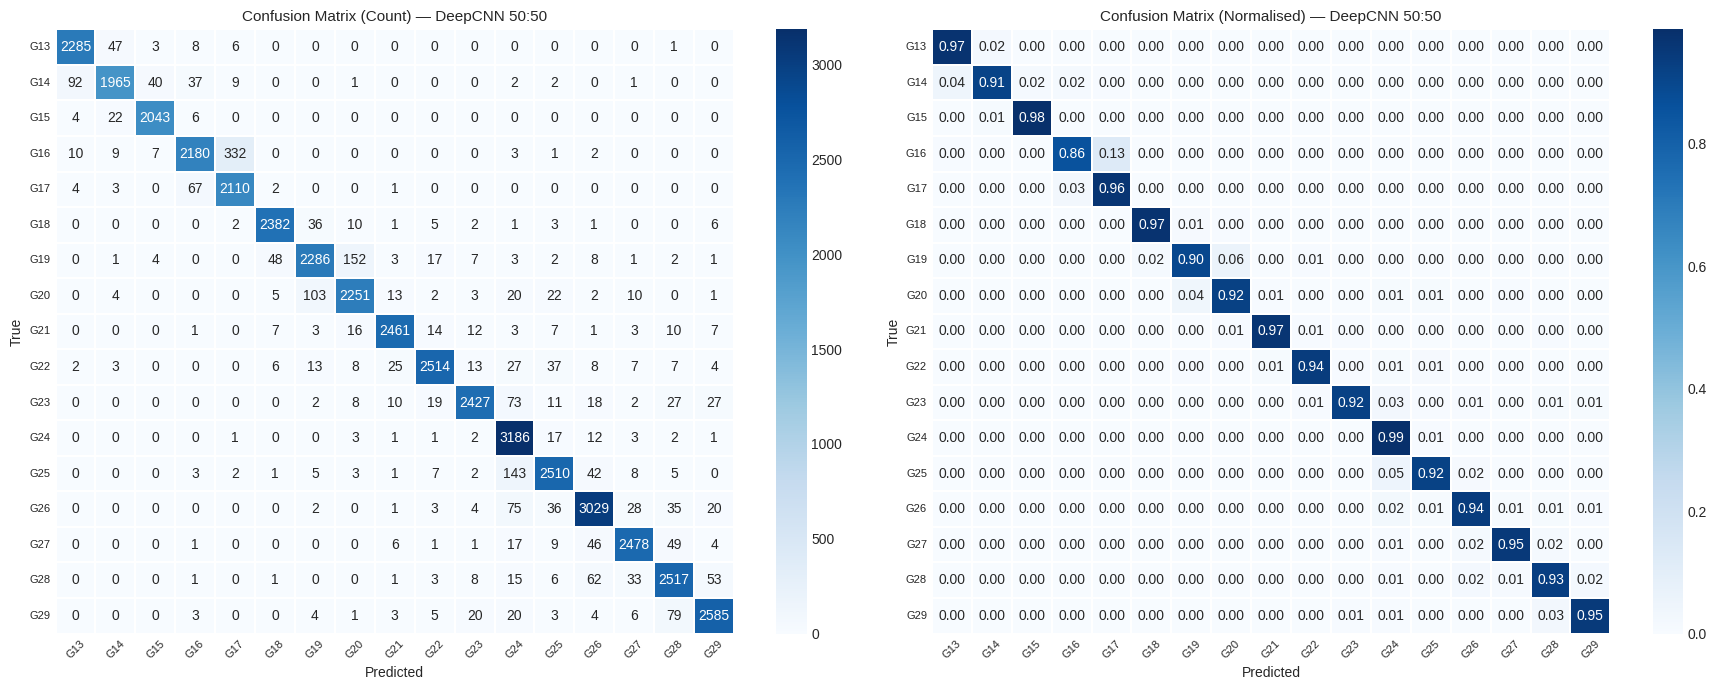

  CM saved → cm_50_50.png


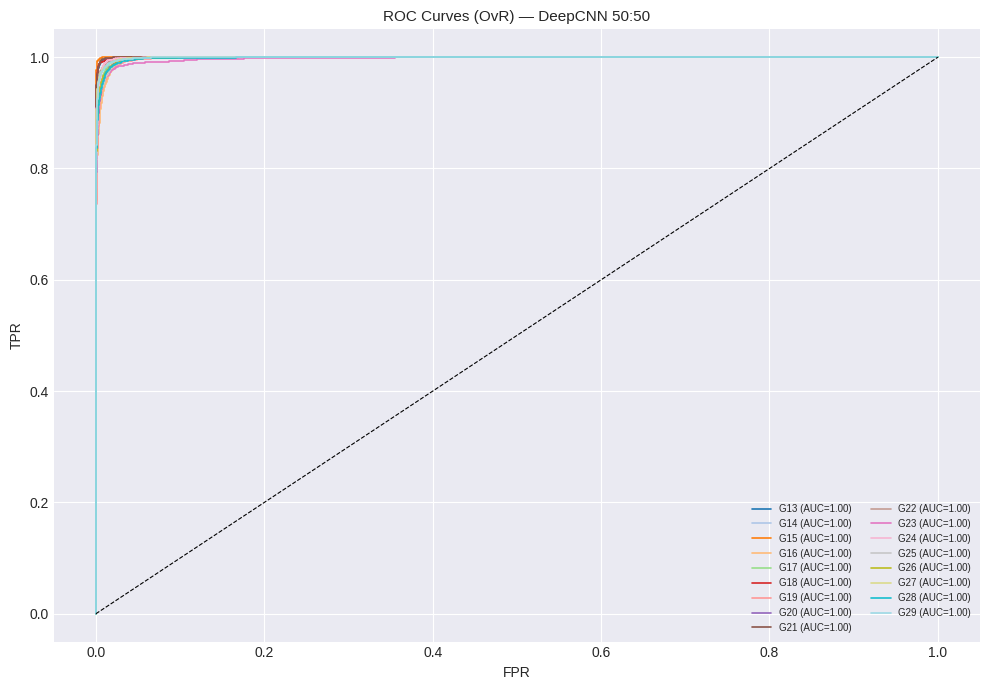

  ROC saved → roc_50_50.png

  Results 50:50
  Accuracy      : 0.9407
  Precision (W) : 0.9419
  Recall (W)    : 0.9407
  F1 (W)        : 0.9407
  ROC-AUC (W)   : 0.9989
  Train wall    : 3528.3 s
  Test wall     : 6.85 s
  GFLOPs/win    : -1.0000
  Model saved  → deepcnn_50_50.pt

  FAILURE MODE ANALYSIS — DeepCNN

  Per-class mean accuracy (worst → best):
             G16  0.910  ███████████████████████████
             G19  0.940  ████████████████████████████
             G28  0.946  ████████████████████████████
             G25  0.946  ████████████████████████████
             G20  0.950  ████████████████████████████
             G23  0.952  ████████████████████████████
             G14  0.955  ████████████████████████████
             G26  0.957  ████████████████████████████
             G27  0.960  ████████████████████████████
             G22  0.961  ████████████████████████████
             G29  0.967  █████████████████████████████
             G17  0.967  █████████████████████

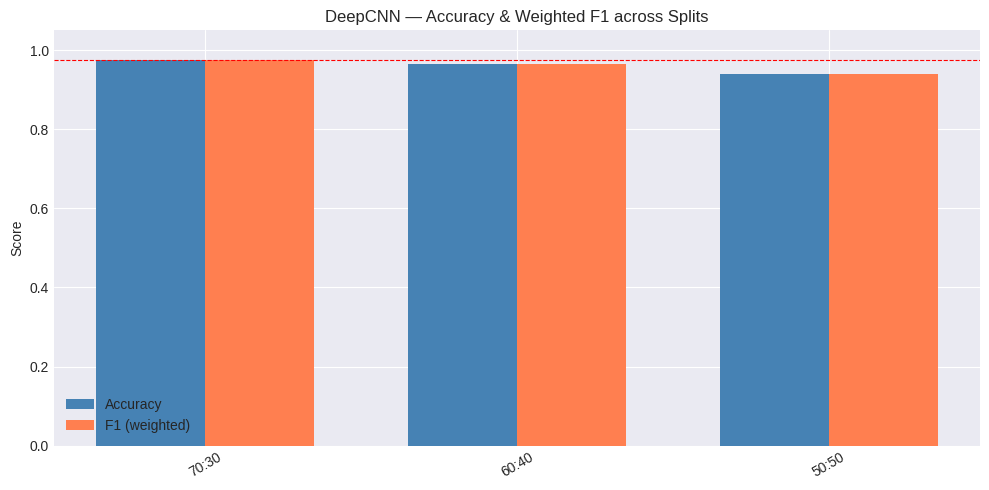

  Summary chart saved → summary_all_splits.png

  FINAL SUMMARY — DeepCNN
split  train_size  test_size  accuracy  precision_w  recall_w     f1_w  roc_auc_w  train_wall_s  test_wall_s  gflops_per_window
70:30       55196      26285  0.973787     0.973978  0.973787 0.973785   0.999687   4866.194832     4.282875               -1.0
60:40       47311      35046  0.965873     0.966095  0.965873 0.965874   0.999517   4162.361544     5.455054               -1.0
50:50       39426      43807  0.940694     0.941861  0.940694 0.940696   0.998942   3528.292584     6.851440               -1.0

  Summary CSV → /kaggle/working/results_deepcnn_AB/summary_all_splits.csv
  Plots       → /kaggle/working/plots_deepcnn_AB
  Models      → /kaggle/working/ckpts_deepcnn_AB

  Best supervised baseline: split 70:30 (Weighted F1 = 0.9738)
  Use this as the reference for SSL experiments.



In [14]:
def main():
    # STEP 1 — Load / checkpoint raw subject data
    print("\n" + "="*70)
    print("  STEP 1 — Loading NinaPro DB7 (Exercise B gestures 13-29)")
    print("="*70)
    subject_loader = SubjectLoader()
    available_sids, n_acc_ch = subject_loader.process_all(Config.SUBJECTS)
    print(f"\n  Available subjects : {available_sids}")
    print(f"  ACC channels       : {n_acc_ch}")

    # STEP 2 — Build windowed dataset
    print("\n" + "="*70)
    print("  STEP 2 — Building Windowed Dataset")
    print("="*70)
    X, y, n_channels = subject_loader.build_windows(available_sids, n_acc_ch)
    n_classes   = Config.GESTURE_MAX - Config.GESTURE_MIN + 1   # 17
    class_names = [f'G{g}' for g in range(Config.GESTURE_MIN,
                                           Config.GESTURE_MAX + 1)]

    print(f"\n  Total windows  : {len(y):,}")
    print(f"  Input channels : {n_channels} (EMG=12, ACC={n_acc_ch})")
    print(f"  Window size    : {Config.WIN_SAMPLES} samples "
          f"({Config.WIN_MS} ms @ {Config.TARGET_FS} Hz)")
    print(f"  Classes        : {n_classes} → {class_names}")

    uniq, cnts = np.unique(y, return_counts=True)
    for u, c in zip(uniq, cnts):
        print(f"    {class_names[u]:>6s}: {c:>7,} windows ({c/len(y)*100:.1f}%)")

    # STEP 3 — Train & Evaluate for each split
    print("\n" + "="*70)
    print("  STEP 3 — Training & Evaluation (DeepCNN, 2 splits)")
    print("="*70)
    experiment  = SplitExperiment(X, y, n_channels, n_classes, class_names)
    all_metrics = []

    for train_frac, test_frac in Config.SPLIT_RATIOS:
        metrics, y_true, y_proba = experiment.run(train_frac, test_frac)
        all_metrics.append(metrics)
        tag   = metrics['split'].replace(':', '_')
        jpath = Config.RESULTS_DIR / f'metrics_{tag}.json'
        m_save = {k: (v if not isinstance(v, dict) else v)
                  for k, v in metrics.items()}
        with open(jpath, 'w') as f:
            json.dump(m_save, f, indent=2)
        gc.collect()

    # Failure mode analysis
    best_split = analyse_failure_modes(all_metrics, class_names)

    # Save full summary CSV
    rows = []
    for m in all_metrics:
        row = {k: v for k, v in m.items() if k != 'per_class_acc'}
        rows.append(row)
    df       = pd.DataFrame(rows)
    csv_path = Config.RESULTS_DIR / 'summary_all_splits.csv'
    df.to_csv(csv_path, index=False)

    print(f"\n{'='*70}")
    print("  FINAL SUMMARY — DeepCNN")
    print(f"{'='*70}")
    print(df[['split', 'train_size', 'test_size',
              'accuracy', 'precision_w', 'recall_w',
              'f1_w', 'roc_auc_w',
              'train_wall_s', 'test_wall_s',
              'gflops_per_window']].to_string(index=False))
    print(f"\n  Summary CSV → {csv_path}")
    print(f"  Plots       → {Config.PLOT_DIR}")
    print(f"  Models      → {Config.CKPT_DIR}")
    print(f"\n  Best supervised baseline: split {best_split['split']}"
          f" (Weighted F1 = {best_split['f1_w']:.4f})")
    print("  Use this as the reference for SSL experiments.\n")


if __name__ == '__main__':
    main()
